In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy

# Data

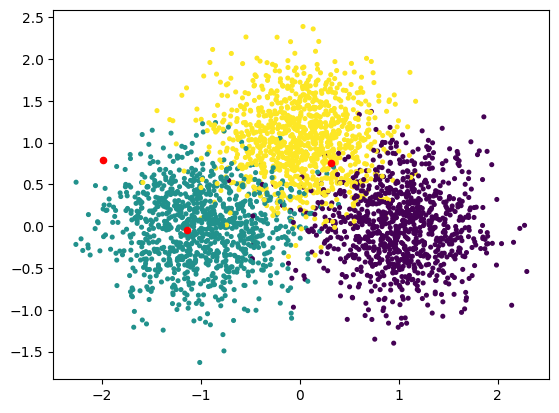

In [2]:
p = [1/3, 1/3, 1/3]
mu = [[1, 0], [-1, 0], [0, 1]]
sigma = [[0.2, 0], [0, 0.2]]

samples = []
sample_class = []
for i in range(3000):
    z = np.argmax(np.random.multinomial(1, p))
    curr_sample = np.random.multivariate_normal(mu[z], sigma)
    samples.append(curr_sample)
    sample_class.append(z)

samples = np.array(samples)
initial_mean = samples[np.random.randint(0, len(samples), 3), :]

plt.figure()
plt.scatter(samples[:, 0], samples[:, 1], 7, sample_class)
plt.scatter(initial_mean[:, 0], initial_mean[:, 1], 20, 'r')

# Models

In [3]:
class Encoder(nn.Module):
    def __init__(self, in_dim, encode_dim) -> None:
        super().__init__()
        self.ln1 = nn.Linear(in_dim, 8)
        self.ln2 = nn.Linear(8, encode_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.ln1(x))
        x = self.relu(self.ln2(x))

        return x

class Decoder(nn.Module):
    def __init__(self, in_dim, out_dim) -> None:
        super().__init__()
        self.ln1 = nn.Linear(in_dim, 8)
        self.ln2 = nn.Linear(8, out_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.ln1(x))
        x = self.ln2(x)
        return x

## Autoencoder - check if encoder, decoder are good

In [156]:
class Model(nn.Module):
    def __init__(self, in_dim, encode_dim, out_dim) -> None:
        super().__init__()
        self.encoder = Encoder(in_dim, encode_dim)
        self.decoder = Decoder(encode_dim, out_dim)
    
    def encode(self, x):
        return self.encoder(x)
    
    def forward(self, x):
        return self.decoder(self.encoder(x))
    
    def loss(self, x):
        recon = self.forward(x)
        recon_loss = torch.mean(torch.square(recon - x))

        return recon_loss


data = torch.tensor(samples, dtype=torch.float)
ae_model = Model(in_dim=data.shape[1], encode_dim=data.shape[1], out_dim=data.shape[1])
optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.001)

for epoch in range(1000):
    optimizer.zero_grad()
    loss = ae_model.loss(data)
    loss.backward()
    optimizer.step()

    if epoch%5 == 0:
        print(f'epoch : {epoch}, loss : {loss}')

epoch : 0, loss : 0.9533404111862183
epoch : 5, loss : 0.9388754963874817
epoch : 10, loss : 0.9249762296676636
epoch : 15, loss : 0.9113546013832092
epoch : 20, loss : 0.8977213501930237
epoch : 25, loss : 0.8839374780654907
epoch : 30, loss : 0.8699395060539246
epoch : 35, loss : 0.8556074500083923
epoch : 40, loss : 0.8408387899398804
epoch : 45, loss : 0.8256633877754211
epoch : 50, loss : 0.8101540803909302
epoch : 55, loss : 0.794404923915863
epoch : 60, loss : 0.7784833908081055
epoch : 65, loss : 0.7623927593231201
epoch : 70, loss : 0.746082603931427
epoch : 75, loss : 0.729459285736084
epoch : 80, loss : 0.7124208807945251
epoch : 85, loss : 0.694786787033081
epoch : 90, loss : 0.6763659119606018
epoch : 95, loss : 0.6570505499839783
epoch : 100, loss : 0.6366754770278931
epoch : 105, loss : 0.6149225234985352
epoch : 110, loss : 0.5915788412094116
epoch : 115, loss : 0.5664137005805969
epoch : 120, loss : 0.5392014384269714
epoch : 125, loss : 0.5105130076408386
epoch : 130,

In [157]:
test_samples = []
test_sample_class = []
for i in range(1000):
    z = np.argmax(np.random.multinomial(1, p))
    curr_sample = np.random.multivariate_normal(mu[z], sigma)
    test_samples.append(curr_sample)
    test_sample_class.append(z)

test_samples = np.array(test_samples)
test_data = torch.tensor(test_samples, dtype=torch.float)

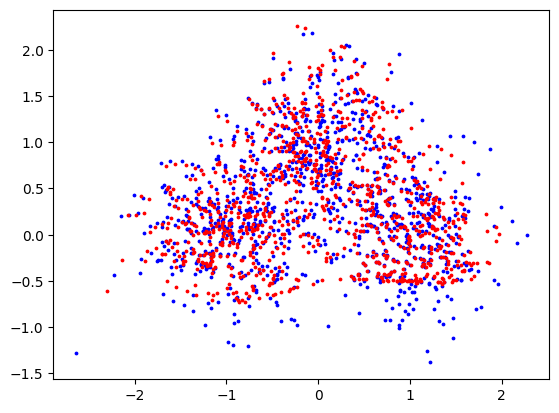

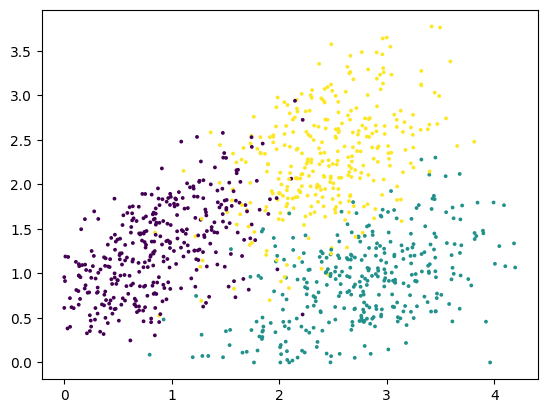

In [158]:
test_data_recon = ae_model(test_data).detach().numpy()
test_data_encode = ae_model.encode(test_data).detach().numpy()

plt.figure()
plt.scatter(test_samples[:, 0], test_samples[:, 1], 3, 'b')
plt.scatter(test_data_recon[:, 0], test_data_recon[:, 1], 3, 'r')

plt.figure()
plt.scatter(test_data_encode[:, 0], test_data_encode[:, 1], 3, test_sample_class)

## VAE - reparametrization trick

In [19]:
class Sampler(nn.Module):
    def __init__(self, in_dim) -> None:
        super().__init__()
        self.mu_head = nn.Linear(in_dim, 2)
        self.sigma_head = nn.Linear(in_dim, 1)

    def forward(self, x):
        mu = self.mu_head(x)
        sigma = torch.exp(self.sigma_head(x)) # exponentiate

        epsilon = torch.tensor(np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], mu.shape[0]), dtype=torch.float)
        sample = mu + torch.mul(sigma, epsilon)

        return mu, sigma, sample

In [20]:
class Model(nn.Module):
    def __init__(self, in_dim, encode_dim, out_dim) -> None:
        super().__init__()
        self.encoder = Encoder(in_dim, encode_dim)
        self.sampler = Sampler(encode_dim)
        self.decoder = Decoder(2, out_dim)
    
    def encode(self, x):
        mu, sigma, z = self.sampler(self.encoder(x))
        return mu, sigma, z
    
    def forward(self, x):
        mu, sigma, z = self.sampler(self.encoder(x))
        self.mu = mu
        self.sigma = sigma
        self.z = z
        return self.decoder(z)
    
    def recon_loss(self, x):
        recon = self.forward(x)
        loss = torch.mean(torch.square(recon - x))
        return loss

    def KL_loss(self):
        # I = torch.tensor([[1, 0], [0, 1]], dtype=torch.float).repeat(self.sigma.shape[0], 1, 1)
        # cov = torch.mul(self.sigma[:, :, None], I)
        # loss = 1/2*(torch.log(1/torch.linalg.det(cov)) - self.mu.shape[0] + torch.trace(cov) + torch.sum(torch.square(self.mu)))
        # loss = torch.sum(torch.square(self.sigma)) + torch.sum(torch.square(self.mu)) - torch.sum(torch.log(self.sigma)) - self.mu.shape[0]/2
        loss = torch.sum(-2*torch.log(self.sigma)) - self.mu.shape[1]*self.mu.shape[0]/2 + torch.sum(torch.square(self.sigma)) + torch.sum(torch.square(self.mu))/2
        return loss
    
    def loss(self, x):
        return self.recon_loss(x), self.KL_loss()


data = torch.tensor(samples, dtype=torch.float)
vae_model = Model(in_dim=data.shape[1], encode_dim=8, out_dim=data.shape[1])
optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.01)

for epoch in range(5000):
    optimizer.zero_grad()
    recon_loss, KL_loss = vae_model.loss(data)
    loss = recon_loss + 0.0001*KL_loss
    loss.backward()
    optimizer.step()

    if epoch%5 == 0:
        print(f'epoch : {epoch}, loss : {loss}, recon_loss : {recon_loss}, KL_loss : {KL_loss}')

epoch : 0, loss : 1.2307146787643433, recon_loss : 1.2117594480514526, KL_loss : 189.5520782470703
epoch : 5, loss : 0.8024793863296509, recon_loss : 0.7926844358444214, KL_loss : 97.94963073730469
epoch : 10, loss : 0.6952363848686218, recon_loss : 0.6675058007240295, KL_loss : 277.3056335449219
epoch : 15, loss : 0.6707944869995117, recon_loss : 0.6545628905296326, KL_loss : 162.31626892089844
epoch : 20, loss : 0.6672158241271973, recon_loss : 0.6616449952125549, KL_loss : 55.708030700683594
epoch : 25, loss : 0.6550931334495544, recon_loss : 0.6527805328369141, KL_loss : 23.12606430053711
epoch : 30, loss : 0.649030327796936, recon_loss : 0.6471158266067505, KL_loss : 19.145130157470703
epoch : 35, loss : 0.6456164717674255, recon_loss : 0.6432273983955383, KL_loss : 23.89057159423828
epoch : 40, loss : 0.6435216069221497, recon_loss : 0.6408721208572388, KL_loss : 26.494686126708984
epoch : 45, loss : 0.6410179138183594, recon_loss : 0.6380700469017029, KL_loss : 29.47854614257812

In [21]:
test_samples = []
test_sample_class = []
for i in range(1000):
    z = np.argmax(np.random.multinomial(1, p))
    curr_sample = np.random.multivariate_normal(mu[z], sigma)
    test_samples.append(curr_sample)
    test_sample_class.append(z)

test_samples = np.array(test_samples)
test_data = torch.tensor(test_samples, dtype=torch.float)

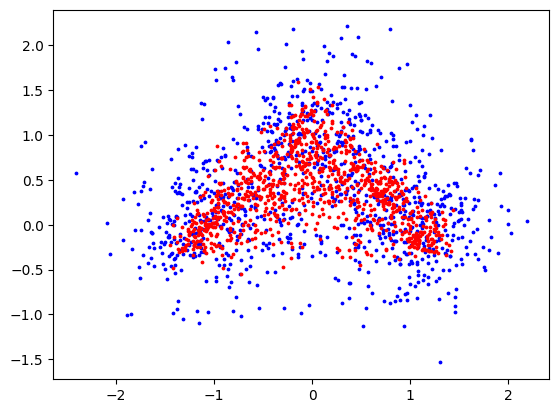

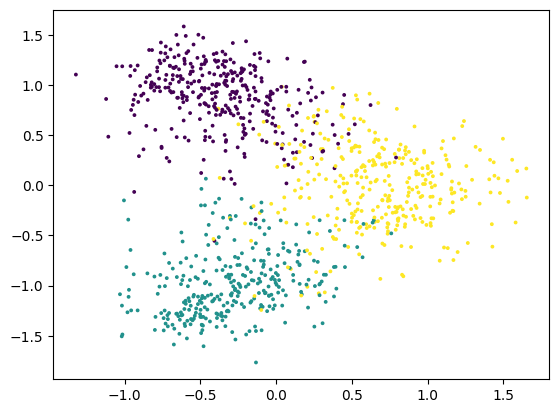

In [22]:
test_data_recon = vae_model(test_data).detach().numpy()
test_data_mu, test_data_sigma, test_data_z = vae_model.encode(test_data)
test_data_mu = test_data_mu.detach().numpy()
test_data_sigma = test_data_sigma.detach().numpy()
test_data_z = test_data_z.detach().numpy()


plt.figure()
plt.scatter(test_samples[:, 0], test_samples[:, 1], 3, 'b')
plt.scatter(test_data_recon[:, 0], test_data_recon[:, 1], 3, 'r')

plt.figure()
plt.scatter(test_data_mu[:, 0], test_data_mu[:, 1], 3, test_sample_class)

## VAE - log derivative trick

In [32]:
class Sampler(nn.Module):
    def __init__(self, in_dim) -> None:
        super().__init__()
        self.mu_head = nn.Linear(in_dim, 2)
        self.sigma_head = nn.Linear(in_dim, 1)

    def forward(self, x):
        mu = self.mu_head(x)
        sigma = torch.exp(self.sigma_head(x)) # exponentiate
        return mu, sigma


class GradLayer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, mu, sigma, sample, reconn):
        ctx.save_for_backward(x, mu, sigma, sample, reconn)
        return reconn
    
    @staticmethod
    def backward(ctx, grad_output):
        x, mu, sigma, sample, reconn = ctx.saved_tensors
        f_x = torch.sum((reconn - x)**2, dim=1, keepdim=True)
        mu_grad = ((sample - mu)/sigma**2)*f_x
        sigma_grad = (-1/sigma + (1/sigma**3)*torch.sum((sample - mu)**2, dim=1, keepdim=True))*f_x
        sample_grad = None
        data_grad = None
        return data_grad, mu_grad, sigma_grad, sample_grad, grad_output
    

class Model(nn.Module):
    def __init__(self, in_dim, encode_dim, out_dim):
        super().__init__()
        self.encoder = Encoder(in_dim, encode_dim)
        self.sampler = Sampler(encode_dim)
        self.decoder = Decoder(2, out_dim)
        self.gl = GradLayer.apply
    
    def encode(self, x):
        mu, sigma = self.sampler(self.encoder(x))
        return mu, sigma

    def forward(self, x):
        mu, sigma = self.sampler(self.encoder(x))
        self.mu = mu
        self.sigma = sigma
        epsilon = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], mu.shape[0])
        sample = torch.tensor(mu.detach().numpy() + sigma.detach().numpy()*epsilon, dtype=torch.float)
        out = self.decoder(sample)
        reconn = self.gl(x, self.mu, self.sigma, sample, out)
        return reconn
    
    def recon_loss(self, x):
        reconn = self.forward(x)
        loss = torch.mean(torch.sum((reconn - x)**2, dim=1))
        return loss

    def KL_loss(self):
        # I = torch.tensor([[1, 0], [0, 1]], dtype=torch.float).repeat(self.sigma.shape[0], 1, 1)
        # cov = torch.mul(self.sigma[:, :, None], I)
        # loss = 1/2*(torch.log(1/torch.linalg.det(cov)) - self.mu.shape[0] + torch.trace(cov) + torch.sum(torch.square(self.mu)))
        # loss = torch.sum(torch.square(self.sigma)) + torch.sum(torch.square(self.mu)) - torch.sum(torch.log(self.sigma)) - self.mu.shape[0]/2
        loss = torch.sum(-2*torch.log(self.sigma)) - self.mu.shape[1]*self.mu.shape[0]/2 + torch.sum(torch.square(self.sigma)) + torch.sum(torch.square(self.mu))/2
        return loss

    def loss(self, x):
        return self.recon_loss(x), self.KL_loss()


data = torch.tensor(samples, dtype=torch.float)
vae_model = Model(in_dim=data.shape[1], encode_dim=8, out_dim=data.shape[1])
optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.0001)

for epoch in range(5000):
    optimizer.zero_grad()
    recon_loss, KL_loss = vae_model.loss(data)
    loss = recon_loss + 0.0001*KL_loss
    loss.backward()
    optimizer.step()

    if epoch%5 == 0:
        print(f'epoch : {epoch}, loss : {loss}, recon_loss : {recon_loss}, KL_loss : {KL_loss}')

         

epoch : 0, loss : 1.4319270849227905, recon_loss : 1.3638153076171875, KL_loss : 681.1177368164062
epoch : 5, loss : 1.4366509914398193, recon_loss : 1.3679972887039185, KL_loss : 686.5372314453125
epoch : 10, loss : 1.4337882995605469, recon_loss : 1.3645830154418945, KL_loss : 692.0523681640625
epoch : 15, loss : 1.4290733337402344, recon_loss : 1.3593053817749023, KL_loss : 697.6798095703125
epoch : 20, loss : 1.4305318593978882, recon_loss : 1.3601826429367065, KL_loss : 703.4924926757812
epoch : 25, loss : 1.429669737815857, recon_loss : 1.3587337732315063, KL_loss : 709.3592529296875
epoch : 30, loss : 1.4287282228469849, recon_loss : 1.357203483581543, KL_loss : 715.2468872070312
epoch : 35, loss : 1.4109747409820557, recon_loss : 1.338857650756836, KL_loss : 721.1707153320312
epoch : 40, loss : 1.4232964515686035, recon_loss : 1.3505784273147583, KL_loss : 727.1801147460938
epoch : 45, loss : 1.4344990253448486, recon_loss : 1.3611938953399658, KL_loss : 733.0514526367188
epoch

In [24]:
test_samples = []
test_sample_class = []
for i in range(1000):
    z = np.argmax(np.random.multinomial(1, p))
    curr_sample = np.random.multivariate_normal(mu[z], sigma)
    test_samples.append(curr_sample)
    test_sample_class.append(z)

test_samples = np.array(test_samples)
test_data = torch.tensor(test_samples, dtype=torch.float)

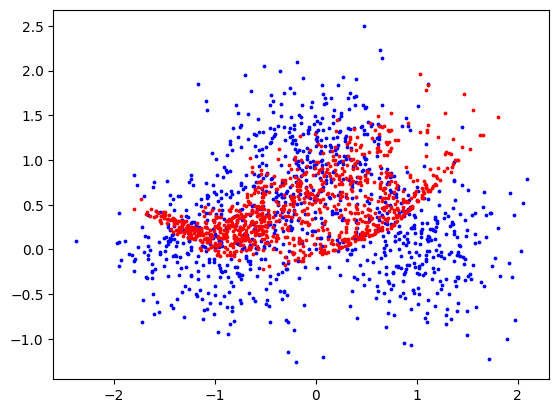

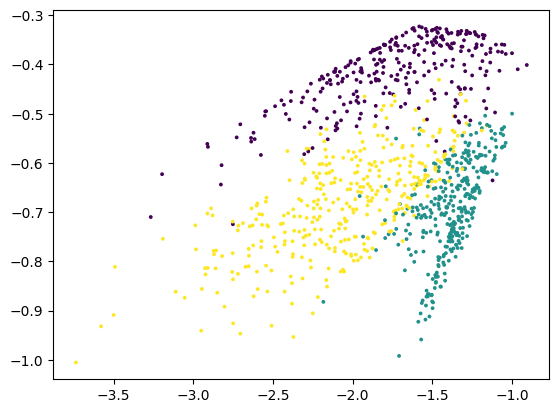

In [31]:
test_data_recon = vae_model(test_data).detach().numpy()
test_data_mu, test_data_sigma = vae_model.encode(test_data)
test_data_mu = test_data_mu.detach().numpy()
test_data_sigma = test_data_sigma.detach().numpy()


plt.figure()
plt.scatter(test_samples[:, 0], test_samples[:, 1], 3, 'b')
plt.scatter(test_data_recon[:, 0], test_data_recon[:, 1], 3, 'r')

plt.figure()
plt.scatter(test_data_mu[:, 0], test_data_mu[:, 1], 3, test_sample_class)

## VAE - torch distributions reparameterization

Torch Distributions provide easy wasy of defining distribution usign output of neural networks (i.e. parameters of those distributions). There are a lot of distributions to pick from and the module provide sseveral other functionalities as well e.g. - 
1. Sampling from those distributions : there are 2 ways of sampling available
    a. dist.sample()
    b. dist.rsample() - sample using reparameterization trick (only possible for distributions that have dist.has_rsample == True)
2. Calculating distribution based stats such as log probability of sample, entropy of distibution, KL_divergence can be calculated between two distributions as well.


Below is an example of sampling 1000 samples from a Multivariate Normal distribution.

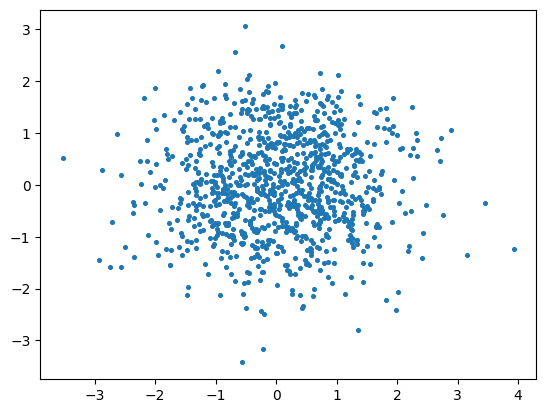

In [37]:
mean = torch.tensor([0, 0], dtype=torch.float)
std = torch.tensor([[1, 0], [0, 1]], dtype=torch.float)
dist = torch.distributions.MultivariateNormal(mean, std)
all_samples = []
for i in range(1000):
    all_samples.append(dist.sample().numpy())

all_samples = np.array(all_samples)
plt.figure()
plt.scatter(all_samples[:, 0], all_samples[:, 1], 7)

In the above case we sampled from one distribution only. But what if we have a different distribution for each data point in the batch, can we sample from multiple distibutions simultaneously? YES, it's very easy and straighforward, just add a batch dimension and define parameters for each data point. E.g. below our batch has 3 data points and we define three Multivariate Normal distributions with mean.shape = [3, 2] and cov.shape = [3, 2, 2]

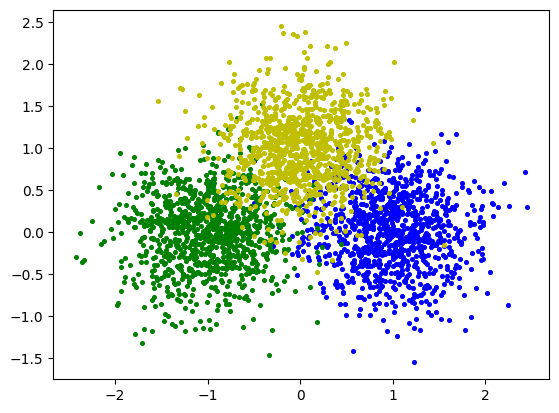

In [47]:
mean = torch.tensor([[1, 0], [-1, 0], [0, 1]], dtype=torch.float)
std = torch.tensor([[0.2, 0], [0, 0.2]], dtype=torch.float)
std = std.repeat(3, 1, 1)
dist = torch.distributions.MultivariateNormal(mean, std)
all_samples = []
for i in range(1000):
    all_samples.append(dist.rsample().numpy())

all_samples = np.array(all_samples)
plt.figure()
plt.scatter(all_samples[:, 0, 0], all_samples[:, 0, 1], 7, 'b')
plt.scatter(all_samples[:, 1, 0], all_samples[:, 1, 1], 7, 'g')
plt.scatter(all_samples[:, 2, 0], all_samples[:, 2, 1], 7, 'y')

In [82]:
class DistributionSampler(nn.Module):
    def __init__(self, in_dim) -> None:
        super().__init__()
        self.mu_head = nn.Linear(in_dim, 2)
        self.sigma_head = nn.Linear(in_dim, 1)
    
    def forward(self, x):
        mu = self.mu_head(x)
        sigma = torch.exp(self.sigma_head(x))
        dist_mu = mu
        dist_sigma = torch.einsum('bi,bjk->bjk', sigma, torch.tensor([[1, 0], [0, 1]], dtype=torch.float).repeat(sigma.shape[0], 1, 1))
        dist = torch.distributions.MultivariateNormal(dist_mu, dist_sigma)
        sample = dist.rsample() # sample using reparameterization trick
        return mu, sigma, sample


class Model(nn.Module):
    def __init__(self, in_dim, encode_dim, out_dim) -> None:
        super().__init__()
        self.encoder = Encoder(in_dim, encode_dim)
        self.sampler = DistributionSampler(encode_dim)
        self.decoder = Decoder(2, out_dim)
    
    def encode(self, x):
        mu, sigma, z = self.sampler(self.encoder(x))
        return mu, sigma, z
    
    def forward(self, x):
        mu, sigma, z = self.sampler(self.encoder(x))
        self.mu = mu
        self.sigma = sigma
        self.z = z
        return self.decoder(z)
    
    def reconn_loss(self, x):
        recon = self.forward(x)
        loss = torch.mean(torch.sum((recon - x)**2, dim=1))
        return loss

    def KL_loss(self):
        # I = torch.tensor([[1, 0], [0, 1]], dtype=torch.float).repeat(self.sigma.shape[0], 1, 1)
        # cov = torch.mul(self.sigma[:, :, None], I)
        # loss = 1/2*(torch.log(1/torch.linalg.det(cov)) - self.mu.shape[0] + torch.trace(cov) + torch.sum(torch.square(self.mu)))
        # loss = torch.sum(torch.square(self.sigma)) + torch.sum(torch.square(self.mu)) - torch.sum(torch.log(self.sigma)) - self.mu.shape[0]/2
        loss = torch.sum(-2*torch.log(self.sigma)) - self.mu.shape[1]*self.mu.shape[0]/2 + torch.sum(torch.square(self.sigma)) + torch.sum(torch.square(self.mu))/2
        return loss
    
    def loss(self, x):
        return self.reconn_loss(x), self.KL_loss()


data = torch.tensor(samples, dtype=torch.float)
vae_model = Model(in_dim=data.shape[1], encode_dim=8, out_dim=data.shape[1])
optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.01)

for epoch in range(5000):
    optimizer.zero_grad()
    recon_loss, KL_loss = vae_model.loss(data)
    loss = recon_loss + 0.0001*KL_loss
    loss.backward()
    optimizer.step()

    if epoch%5 == 0:
        print(f'epoch : {epoch}, loss : {loss}, reconn_loss : {recon_loss}, KL_loss : {KL_loss}')

epoch : 0, loss : 1.5444070100784302, lg_trick_loss : 1.462167501449585, KL_loss : 822.394775390625
epoch : 5, loss : 1.405482292175293, lg_trick_loss : 1.3720160722732544, KL_loss : 334.6624755859375
epoch : 10, loss : 1.3333721160888672, lg_trick_loss : 1.325560212135315, KL_loss : 78.11868286132812
epoch : 15, loss : 1.3202641010284424, lg_trick_loss : 1.3191683292388916, KL_loss : 10.9576416015625
epoch : 20, loss : 1.3114049434661865, lg_trick_loss : 1.3046406507492065, KL_loss : 67.64313507080078
epoch : 25, loss : 1.2997761964797974, lg_trick_loss : 1.2886805534362793, KL_loss : 110.95628356933594
epoch : 30, loss : 1.2876088619232178, lg_trick_loss : 1.2642812728881836, KL_loss : 233.27578735351562
epoch : 35, loss : 1.2514970302581787, lg_trick_loss : 1.2070430517196655, KL_loss : 444.53961181640625
epoch : 40, loss : 1.183815360069275, lg_trick_loss : 1.0844831466674805, KL_loss : 993.3223876953125
epoch : 45, loss : 1.1223756074905396, lg_trick_loss : 0.9444618225097656, KL_

In [85]:
test_samples = []
test_sample_class = []
for i in range(1000):
    z = np.argmax(np.random.multinomial(1, p))
    curr_sample = np.random.multivariate_normal(mu[z], sigma)
    test_samples.append(curr_sample)
    test_sample_class.append(z)

test_samples = np.array(test_samples)
test_data = torch.tensor(test_samples, dtype=torch.float)

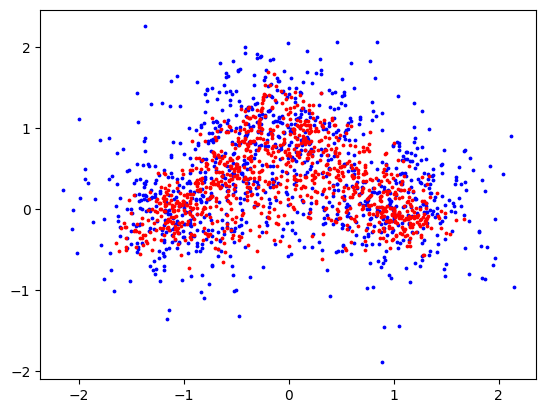

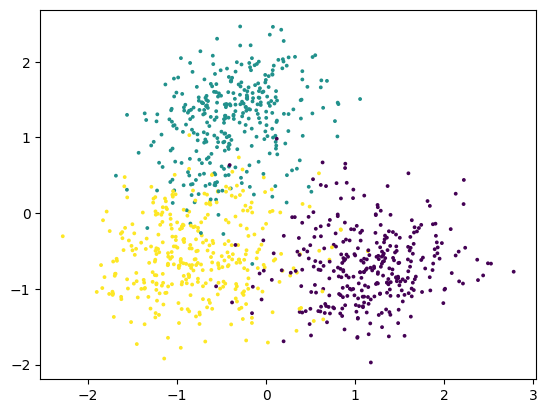

In [86]:
test_data_recon = vae_model(test_data).detach().numpy()
test_data_mu, test_data_sigma, test_data_z = vae_model.encode(test_data)
test_data_mu = test_data_mu.detach().numpy()
test_data_sigma = test_data_sigma.detach().numpy()

plt.figure()
plt.scatter(test_samples[:, 0], test_samples[:, 1], 3, 'b')
plt.scatter(test_data_recon[:, 0], test_data_recon[:, 1], 3, 'r')

plt.figure()
plt.scatter(test_data_mu[:, 0], test_data_mu[:, 1], 3, test_sample_class)

## VAE - torch distributions log derivative trick

In [48]:
class DistributionSampler(nn.Module):
    def __init__(self, in_dim) -> None:
        super().__init__()
        self.mu_head = nn.Linear(in_dim, 2)
        self.sigma_head = nn.Linear(in_dim, 1)
    
    def forward(self, x):
        mu = self.mu_head(x)
        sigma = torch.exp(self.sigma_head(x))
        dist_mu = mu
        dist_sigma = torch.einsum('bi,bjk->bjk', sigma, torch.tensor([[1, 0], [0, 1]], dtype=torch.float).repeat(sigma.shape[0], 1, 1))
        dist = torch.distributions.MultivariateNormal(dist_mu, dist_sigma)
        sample = dist.sample() # NOTE - not sampling using reparameterization trick
        log_prob = dist.log_prob(sample)
        return mu, sigma, sample, log_prob


class Model(nn.Module):
    def __init__(self, in_dim, encode_dim, out_dim):
        super().__init__()
        self.encoder = Encoder(in_dim, encode_dim)
        self.sampler = DistributionSampler(encode_dim)
        self.decoder = Decoder(2, out_dim)
    
    def encode(self, x):
        mu, sigma, sample, log_prob = self.sampler(self.encoder(x))
        return mu, sigma, sample, log_prob
    
    def forward(self, x):
        mu, sigma, sample, log_prob = self.sampler(self.encoder(x))
        mu.retain_grad()
        sigma.retain_grad()
        self.mu = mu
        self.sigma = sigma
        self.log_prob = log_prob
        recon = self.decoder(sample)
        return recon
    
    def recon_loss(self, x):
        recon = self.forward(x)
        loss = torch.sum((recon - x)**2, dim=1, keepdim=True)
        return loss
    
    def KL_loss(self):
        loss = torch.sum(-2*torch.log(self.sigma)) - self.mu.shape[1]*self.mu.shape[0]/2 + torch.sum(torch.square(self.sigma)) + torch.sum(torch.square(self.mu))/2
        return loss
    
    def loss(self, x):
        recon = self.recon_loss(x)
        return torch.mean(self.log_prob*recon.detach()), self.KL_loss(), torch.mean(recon)


data = torch.tensor(samples, dtype=torch.float)
vae_model = Model(in_dim=data.shape[1], encode_dim=8, out_dim=data.shape[1])
optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.0001)

for epoch in range(2000):
    optimizer.zero_grad()
    enc_loss_reconn, enc_loss_KL, dec_loss = vae_model.loss(data)
    loss = enc_loss_reconn + 0.0001*enc_loss_KL + dec_loss
    loss.backward()
    optimizer.step()

    if epoch%5 == 0:
        print(f'epoch : {epoch}, loss : {loss}, enc_loss_reconn : {enc_loss_reconn}, KL_loss : {enc_loss_KL}, dec_loss : {dec_loss}')
        

epoch : 0, loss : -3.589320182800293, enc_loss_reconn : -5.410449504852295, KL_loss : 1447.448974609375, dec_loss : 1.676384449005127
epoch : 5, loss : -3.5981321334838867, enc_loss_reconn : -5.414122581481934, KL_loss : 1416.7823486328125, dec_loss : 1.6743122339248657
epoch : 10, loss : -3.592409610748291, enc_loss_reconn : -5.413626670837402, KL_loss : 1386.6802978515625, dec_loss : 1.682548999786377
epoch : 15, loss : -3.551413059234619, enc_loss_reconn : -5.357069492340088, KL_loss : 1357.2431640625, dec_loss : 1.6699317693710327
epoch : 20, loss : -3.535658359527588, enc_loss_reconn : -5.328327178955078, KL_loss : 1328.6832275390625, dec_loss : 1.659800410270691
epoch : 25, loss : -3.5386605262756348, enc_loss_reconn : -5.332208633422852, KL_loss : 1300.7203369140625, dec_loss : 1.6634758710861206
epoch : 30, loss : -3.5627169609069824, enc_loss_reconn : -5.336899757385254, KL_loss : 1273.3961181640625, dec_loss : 1.6468433141708374
epoch : 35, loss : -3.491905689239502, enc_loss

KeyboardInterrupt: 

In [49]:
test_samples = []
test_sample_class = []
for i in range(1000):
    z = np.argmax(np.random.multinomial(1, p))
    curr_sample = np.random.multivariate_normal(mu[z], sigma)
    test_samples.append(curr_sample)
    test_sample_class.append(z)

test_samples = np.array(test_samples)
test_data = torch.tensor(test_samples, dtype=torch.float)

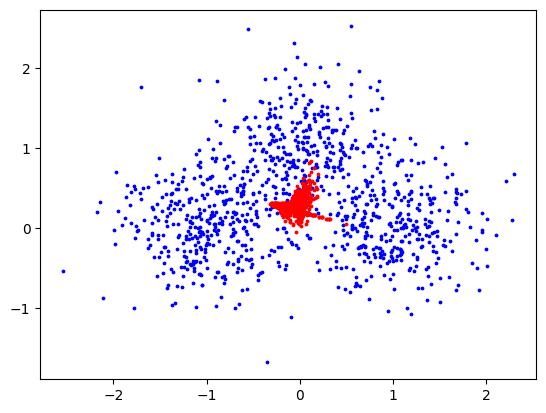

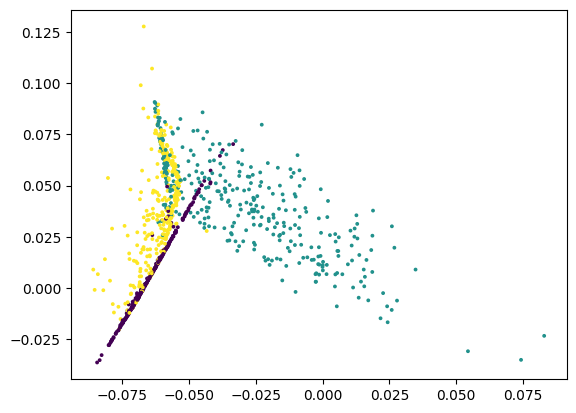

In [50]:
test_data_recon = vae_model(test_data).detach().numpy()
test_data_mu, test_data_sigma, test_data_z, test_data_log_prob = vae_model.encode(test_data)
test_data_mu = test_data_mu.detach().numpy()
test_data_sigma = test_data_sigma.detach().numpy()

plt.figure()
plt.scatter(test_samples[:, 0], test_samples[:, 1], 3, 'b')
plt.scatter(test_data_recon[:, 0], test_data_recon[:, 1], 3, 'r')

plt.figure()
plt.scatter(test_data_mu[:, 0], test_data_mu[:, 1], 3, test_sample_class)

# Appendix

## experimentation with grad and backward for log drivative trick

In [14]:
class CustomLayer(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, x1, x2):
        ctx.save_for_backward(x1, x2)
        return torch.tensor(2.0)
    
    @staticmethod
    def backward(ctx, grad_output):
        x1, x2 = ctx.saved_tensors
        print(x1, x2)
        return grad_output*2, grad_output

In [15]:
d1 = torch.tensor([1, 1, 1], dtype=torch.float)
d2 = torch.tensor([1, 2, 3], dtype=torch.float)
w = torch.tensor([1, 2, 3], dtype=torch.float, requires_grad=True)
cl = CustomLayer.apply

u1 = torch.dot(d1, w)
u2 = torch.dot(d2, w)
o = cl(u1, u2)
loss = o**2

print(u1, u2, o, loss)

tensor(6., grad_fn=<DotBackward0>) tensor(14., grad_fn=<DotBackward0>) tensor(2., grad_fn=<CustomLayerBackward>) tensor(4., grad_fn=<PowBackward0>)


In [16]:
print(w.grad, u1.grad, u2.grad, o.grad)
loss.backward()
print(w.grad, u1.grad, u2.grad, o.grad)

None None None None
tensor(6., grad_fn=<DotBackward0>) tensor(14., grad_fn=<DotBackward0>)
tensor([12., 16., 20.]) None None None


/tmp/ipykernel_1051572/1591913650.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  print(w.grad, u1.grad, u2.grad, o.grad)
/tmp/ipykernel_1051572/1591913650.py:3: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pyt

In [17]:
class CustomLayer(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, mu, sigma, loss):
        ctx.save_for_backward(mu, sigma, loss)
        return loss
    
    @staticmethod
    def backward(ctx, grad_output):
        mu, sigma, o = ctx.saved_tensors
        print(mu, sigma, o)
        print(grad_output)
        return grad_output, grad_output, grad_output*1

In [18]:
d = torch.tensor([2], dtype=torch.float)

w1= torch.tensor([2], dtype=torch.float, requires_grad=True)
w2= torch.tensor([3], dtype=torch.float, requires_grad=True)
w3 = torch.tensor([4], dtype=torch.float, requires_grad=True)
cl = CustomLayer.apply

mu = d*w1**2
sigma = d*w2
sample = torch.tensor(mu.detach().numpy() + sigma.detach().numpy()*np.random.randn(1))
o = sample*w3
loss = o**2
loss = cl(mu, sigma, loss)

print(mu, sigma, sample, o, loss)

tensor([8.], grad_fn=<MulBackward0>) tensor([6.], grad_fn=<MulBackward0>) tensor([9.6525], dtype=torch.float64) tensor([38.6100], dtype=torch.float64, grad_fn=<MulBackward0>) tensor([1490.7358], dtype=torch.float64, grad_fn=<CustomLayerBackward>)


In [19]:
print(w1.grad, w2.grad, w3.grad)
loss.backward()
print(w1.grad, w2.grad, w3.grad)

None None None
tensor([8.], grad_fn=<MulBackward0>) tensor([6.], grad_fn=<MulBackward0>) tensor([1490.7358], dtype=torch.float64, grad_fn=<PowBackward0>)
tensor([1.], dtype=torch.float64)
tensor([8.]) tensor([2.]) tensor([745.3679])


In [20]:
2*o*sample

tensor([745.3679], dtype=torch.float64, grad_fn=<MulBackward0>)